# 实验大小

我们可以根据期望的实际显著性界限规划实验。我们需要知道，需要多少观察值，才能让我们的实验运行结果变得有效，然后再来判断实验需要运行多久，以及是否可行。

我们再看看视频中的示例，其中基准点击率为 10%，我们希望操控后点击率上升到 12%。每个小组需要多少观察值，才能检测到此变化？其中功效为 $1-\beta = .80$（即有 80% 的时间检测到 2% 的绝对增加量），I 型错误率为 $\alpha = .05$。

In [1]:
# import packages
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
% matplotlib inline

## 方法 1：试错法

一种方法是试错法。每个样本量都存在一定的功效水平；测试多个样本量将逐渐使我们接近获得期望的功效水平所需的最低样本量。这并不是很高效的方法，但是能够直观地说明实验大小的确定方式。

请按以下步骤填写 `power()` 函数：

1.在零假设下，应该有一个临界值使 I 型错误率达到期望的 α 水平。
  - `se_null`：计算两组在零假设下的比例差异标准差。`p_null` 会提供基础概率。注意，差异分布的方差等于单个分布的方差之和，每个小组有 `n` 个观察值。
  - `null_dist`：为了便于重复利用，它应该是一个 [SciPy 规范对象](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)。分别使用“loc”和“scale”参数指定正态分布的中心和标准差。
  - `p_crit`：计算会导致我们拒绝零假设的分布临界值。`null_dist` 对象的某个方法会帮助我们获得此值（传入期望的错误率 `alpha` 的某个函数）。

2.功效是指在零假设下超过之前获得的临界值的分布比例。
  - `se_alt`：现在朝着另一个方向计算值。它将等于期望的可检测差异下的差异标准差。注意，单个分布的方差现在将不同：一个的成功概率为 `p_null`，另一个的成功概率为 `p_alt`。
  - `alt_dist`：它将是如上所示的 SciPy 规范对象。注意这个对象里的“loc”参数。根据 `power` 函数的设置，它要求 `p_alt` 大于 `p_null`，使差异为正。
  - `beta`：Beta 是 II 型错误的概率，或者特定非零状态未能拒绝零假设的概率。这表示你应该利用 `alt_dist` 和 `p_crit`。

我们已经完成函数的第二部分，这部分会可视化零假设的差异和期望的可检测差异的分布情况。请在后面的单元格中运行该函数，并观察可视化结果，然后用一些断言语句测试代码。如果你想查看答案，请转到下一页。

In [2]:
def power(p_null, p_alt, n, alpha = .05, plot = True):
    """
    Compute the power of detecting the difference in two populations with 
    different proportion parameters, given a desired alpha rate.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected, must be larger than
                p_null
        n     : number of observations made in each group
        alpha : Type-I error rate
        plot  : boolean for whether or not a plot of distributions will be
                created
    
    Output value:
        power : Power to detect the desired difference, under the null.
    """
    
    # Compute the power
    se_null = np.sqrt((p_null * (1-p_null) + p_null * (1-p_null)) / n)
    null_dist = stats.norm(loc = 0, scale = se_null)
    p_crit = null_dist.ppf(1 - alpha)
    
    se_alt  = np.sqrt((p_null * (1-p_null) + p_alt  * (1-p_alt) ) / n)
    alt_dist = stats.norm(loc = p_alt - p_null, scale = se_alt)
    beta = alt_dist.cdf(p_crit)
    
    if plot:
        # Compute distribution heights
        low_bound = null_dist.ppf(.01)
        high_bound = alt_dist.ppf(.99)
        x = np.linspace(low_bound, high_bound, 201)
        y_null = null_dist.pdf(x)
        y_alt = alt_dist.pdf(x)

        # Plot the distributions
        plt.plot(x, y_null)
        plt.plot(x, y_alt)
        plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
                   linestyles = '--')
        plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .5)
        plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .5)
        
        plt.legend(['null','alt'])
        plt.xlabel('difference')
        plt.ylabel('density')
        plt.show()
    
    # return power
    return (1 - beta)
    

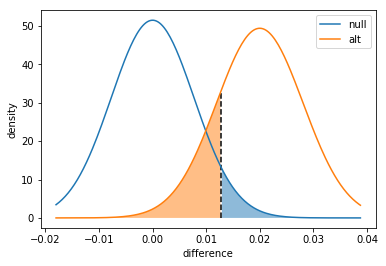

0.81567059294457289

In [6]:
power(.1, .12, 3000)

In [4]:
assert np.isclose(power(.1, .12, 1000, plot = False), 0.4412, atol = 1e-4)
assert np.isclose(power(.1, .12, 3000, plot = False), 0.8157, atol = 1e-4)
assert np.isclose(power(.1, .12, 5000, plot = False), 0.9474, atol = 1e-4)
print('You should see this message if all the assertions passed!')

You should see this message if all the assertions passed!


## 方法 2：分析方法

你已经通过试错法大概了解了功效，现在我们可以通过封闭解计算最小实验大小了。要注意的关键一点是，如果 $\alpha$ 和 $\beta$ 都小于 5，那么确定统计显著性的临界值将在零假设点击率和期望的备择点击率之间。所以，$p_0$ 和 $p_1$ 之间的差异可以再划分为从 $p_0$ 到临界值 $p^*$ 的距离和从 $p^*$ 到 $p_1$ 的距离。

<img src= 'images/ExpSize_Power.png'>

这些细分差异可以用标准误差和 z 分数表示：

$$p^* - p_0 = z_{1-\alpha} SE_{0},$$
$$p_1 - p^* = -z_{\beta} SE_{1};$$

$$p_1 - p_0 = z_{1-\alpha} SE_{0} - z_{\beta} SE_{1}$$

标准误差的计算方法是分布的标准差除以每组的样本数的平方根：

$$SE_{0} = \frac{s_{0}}{\sqrt{n}},$$
$$SE_{1} = \frac{s_{1}}{\sqrt{n}}$$

代替这些值并求解 $n$ 将得出一个公式，使我们能够计算在期望的功效水平检测到指定差异的最小样本量：

$$n = \lceil \big(\frac{z_{\alpha} s_{0} - z_{\beta} s_{1}}{p_1 - p_0}\big)^2 \rceil$$

其中 $\lceil ...\rceil$ 表示顶函数，并且将小数值四舍五入到下个更大的整数。请在下面实现必要的函数变量，然后在后续单元格中测试这些变量。

In [7]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1 - alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt(p_null * (1-p_null) + p_null * (1-p_null))
    sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt  * (1-p_alt) )
    
    # Compute and return minimum sample size
    p_diff = p_alt - p_null
    n = ((z_null*sd_null - z_alt*sd_alt) / p_diff) ** 2
    return np.ceil(n)

In [8]:
experiment_size(.1, .12)

2863.0

In [9]:
assert np.isclose(experiment_size(.1, .12), 2863)
print('You should see this message if the assertion passed!')

You should see this message if the assertion passed!


## 解析注意事项

上述示例是一个单尾检验，备择假设的值比零假设的要大。如果备择假设的比例大于零假设的比例，那么第一部分的功效计算方法将不可行，例如检测到比例参数为 0.88，而零假设的为 0.9。你可能需要重新编写代码来处理这种情形。第二种方法应该不会出现这种问题，我们直接计算了样本量。

如果你需要执行双尾检验，则要注意两大事项。首先，“alpha”参数需要考虑到拒绝区域分成了两个部分。其次，你应该根据最糟糕情形完成计算，即具有最高可变性的备择情形。由于在二项分布中，当 $p = .5$ 时方差最高，并且当 $p$ 接近 0 或 1 时方差会降低，所以在计算必要样本量时，应该选择非常接近 0.5 的备择值作为参考。

注意，上述方法仅考虑了统计显著性，没有考虑实际显著性。需要注意的一点是，如果实验效果的真实大小与期望的实际显著性水平一样，那么均值高于或低于实际显著性界限的概率是 0.5。这甚至没有考虑到置信区间对界限的影响。从某种程度上来说，确定实验大小可以检查你能否通过运行实验获得想要的结果，而不是检查你是否将获得所需的结果。

## 其他方法

还有一些工具和 Python 软件包可以帮助你确定样本量，所以你不需要自己处理每种情形。这个[样本量计算器](http://www.evanmiller.org/ab-testing/sample-size.html)适用于比例，并且提供的结果与上述方法的一样。（但是注意，该计算器针对的是双尾检验。）Python 软件包“statsmodels”在其 [`power` 模块](https://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations)中提供了多种计算功效和样本量的函数。与之前演示的方法不同，零假设和备择假设之间的差异会参数化为效应量（小组均值之间的标准化差异除以标准差）。所以，这些函数不仅仅可用于比例检验。如果我们想完成和之前一样的检验，[`proportion_effectsize`](http://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html) 函数会计算 [Cohen's h](https://en.wikipedia.org/wiki/Cohen%27s_h)，用于衡量效应量。因此，statsmodel 函数的输出应该与上述预期结果不同。这并不是大问题，因为在大多数情形下，你并不会根据具体的观察值数量停止实验，只是根据该值做出一般设计决策。

In [ ]:
# example of using statsmodels for sample size calculation
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# leave out the "nobs" parameter to solve for it
NormalIndPower().solve_power(effect_size = proportion_effectsize(.12, .1), alpha = .05, power = 0.8,
                             alternative = 'larger')

```python

```